## Official dataset creation for 70m

In [50]:
import os
import sys
import torch 
import pickle
import numpy as np
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

seed = 0
np.random.seed(seed)

path = '../../../gld/train-data-probes/data/70m'

In [51]:
with open(os.path.join(path, 'pile/pile_all_mem_status.pkl'), 'rb') as f:
    pile_status = pickle.load(f)

with open(os.path.join(path, 'pile/pile_all_generations.pkl'), 'rb') as f:
    pile_all_generations = pickle.load(f)

with open(os.path.join(path, 'pile/pile_all_tokens.pkl'), 'rb') as f:
    pile_all_tokens = pickle.load(f)

print('Loaded pile data')

with open(os.path.join(path, 'pythia-evals/mem_all_mem_status.pkl'), 'rb') as f:
    status = pickle.load(f)

with open(os.path.join(path, 'pythia-evals/mem_all_generations.pkl'), 'rb') as f:
    mem_all_generations = pickle.load(f)

with open(os.path.join(path, 'pythia-evals/mem_all_tokens.pkl'), 'rb') as f:
    mem_all_tokens = pickle.load(f)

print('Loaded mem data')

Loaded pile data
Loaded mem data


In [52]:
def gen_pile_data(N, tokenizer, min_n_toks : int = None):
    pile = load_dataset('monology/pile-uncopyrighted', split='train', streaming=True)
    sentences = []
    counter = 0
    for i, example in enumerate(pile):
        if min_n_toks is not None:
            toks = tokenizer(example['text'])['input_ids']
            if len(toks) > min_n_toks:
                sentences.append(example['text'])
                counter +=1
        else:
            sentences.append(example['text'])
            counter +=1
        
        if counter == N:
            break

    return sentences

N_PROMPTS = 5000
model_name = "EleutherAI/pythia-70m"
dataset_name = "duped." + model_name.split("-")[-1]
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

mem_data = load_dataset('EleutherAI/pythia-memorized-evals')[dataset_name]
mem_data_toks = [seq for seq in mem_data[:N_PROMPTS]['tokens']]
pile_prompts = gen_pile_data(N_PROMPTS, tokenizer, min_n_toks = 64)

print(len(pile_prompts))
print(len(mem_data_toks))
    
tok_idxs =  (7 * np.arange(10)).tolist() #every 5th token
tok_idxs[-1]= tok_idxs[-1] - 1 #goes from 63 to 62
print(tok_idxs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Resolving data files: 100%|██████████| 30/30 [00:00<00:00, 341.13it/s]


5000
5000
[0, 7, 14, 21, 28, 35, 42, 49, 56, 62]


In [53]:
import pandas as pd

# create df
source = ['pythia-evals' for _ in range(N_PROMPTS)] + ['pile' for _ in range(N_PROMPTS)]
gen = mem_all_generations + pile_all_generations
mem_str = tokenizer.batch_decode(mem_all_tokens, skip_special_tokens=True)

# tokenize pile_prompts
pile_prompts = [tokenizer(prompt, padding='max_length', truncation=True, max_length=64)['input_ids'] for prompt in pile_prompts]
pile_prompts = [tokenizer.decode(prompt) for prompt in pile_prompts]
ground = mem_str + pile_prompts
mem_status = status['tok_by_tok_sim'] + pile_status['tok_by_tok_sim']
char_status = status['char_by_char_sim'] + pile_status['char_by_char_sim']
lev_status = status['lev_distance'] + pile_status['lev_distance']
orig_index = [i for i in range(N_PROMPTS)] + [i for i in range(N_PROMPTS)]
toks = mem_all_tokens + pile_all_tokens

df = pd.DataFrame(list(zip(gen, ground, mem_status, char_status, lev_status, toks, source, orig_index)), 
               columns =['gen', 'ground', 'tok_by_tok_sim', 'char_by_char_sim', 'lev_distance', 'toks', 'source', 'orig_index'])

df.to_csv(os.path.join(path, 'data.csv'), index=False, escapechar='\\')

In [54]:
import pandas as pd

df = pd.read_csv(os.path.join(path, 'data.csv'), escapechar='\\')
df = df.drop_duplicates(subset=['gen', 'ground'], keep='first')
df = df.dropna(subset=['toks'])
len(df)

/tmp/ipykernel_16962/857612337.py:3: DtypeWarning: Columns (1,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, 'data.csv'), escapechar='\\')


9535

### Data cleaning

In [55]:
# remove common patterns
from collections import Counter

def has_repeated_majority(arr, frac = 1/2):
    """
    Check if any value in the array is repeated more than half the length of the array.

    Parameters:
    arr (list): The input list of numbers.

    Returns:
    bool: True if a majority element exists, False otherwise.
    """
    if not arr:
        return False

    count = Counter(arr)
    length = len(arr)

    for key, value in count.items():
        if value > length * frac:
            return True

    return False

def robust_eval(x): 
    try: 
        return eval(x)
    except: 
        print(x)
        return None
    
df['toks'] = df['toks'].apply(lambda x: robust_eval(x))
df = df.dropna(subset=['toks'])
rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if has_repeated_majority(row['toks'], frac=1/4):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

pythia-evals


9534it [00:00, 19888.96it/s]

502


In [56]:
import re

def remove_punc(string):
    return re.sub(r'[\[\]._,\-]', '', string)

def remove_non_numeric(string):
    return re.sub(r'[^\d]', '', string)

def check_repeated_string(string):
    # Remove periods, underscores, dashes, and other special characters
    string = remove_punc(string)
    words = string.split()
    if len(words) == 0:
        return False
    else:
        return all(words[i] == words[i+1] for i in range(len(words)-1))
    
def check_increment(string):
    # Remove periods, underscores, dashes, and other special characters
    numbers = [int(remove_punc(word.strip())) for word in string.split() if remove_punc(word.strip()).isdigit()]
    if len(numbers) < 4:
        return False
    else:
        all_inc = all(numbers[i] == numbers[i+1] - 1 for i in range(len(numbers)-1)) 
        all_dec = all(numbers[i] ==  numbers[i+1] + 1 for i in range(len(numbers)-1))
        return all_inc or all_dec 
    
rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if check_repeated_string(row['gen']) or check_increment(row['gen']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

9032it [00:00, 11589.24it/s]

237


In [57]:
def repeats_subseq(toks, n=10): 
    """
    Returns True if has a tok seq contains a subsequence of length n that is repeated more than once. 
    """
    for i in range(len(toks) - n):
        subseq = toks[i:i+n]
        for j in range(i+1, len(toks) - n):
            if toks[j:j+n] == subseq:
                return True
    return False

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if repeats_subseq(row['toks']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

8795it [00:01, 4806.38it/s]

3134


### Checking memorization scores

In [58]:
# force float on similarity columns
df['tok_by_tok_sim'] = df['tok_by_tok_sim'].astype(float)
df['char_by_char_sim'] = df['char_by_char_sim'].astype(float)
df['lev_distance'] = df['lev_distance'].astype(float)


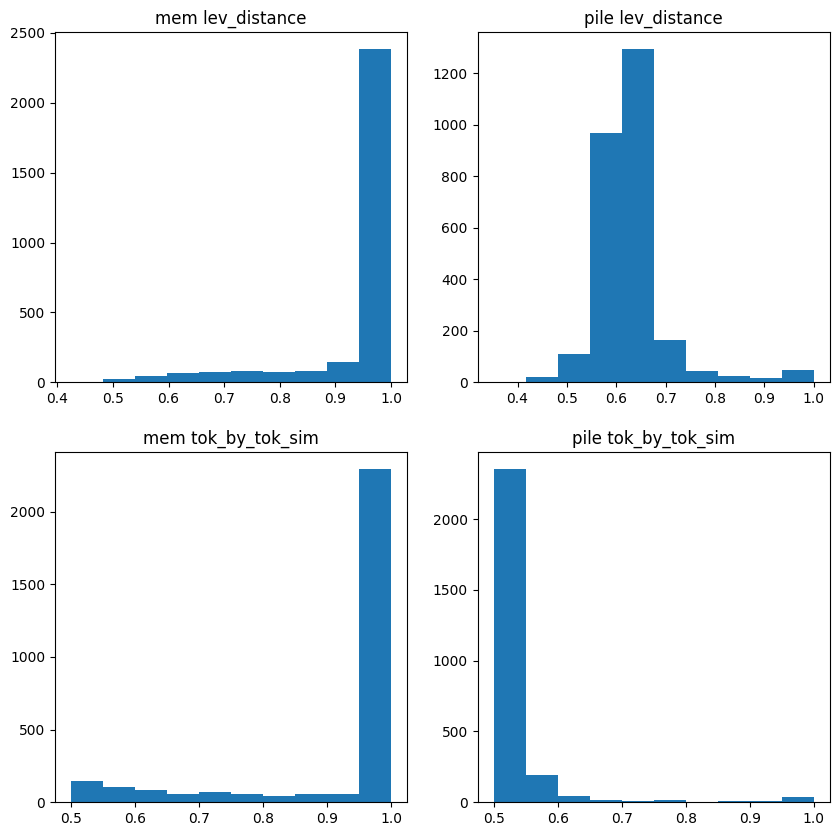

In [59]:
import matplotlib.pyplot as plt

pile_df = df[df['source'] == 'pile']
mem_df = df[df['source'] == 'pythia-evals']

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].hist(mem_df['lev_distance'])
ax[0,1].hist(pile_df['lev_distance'])
ax[1,0].hist(mem_df['tok_by_tok_sim'])
ax[1,1].hist(pile_df['tok_by_tok_sim'])
ax[0,0].set_title('mem lev_distance')
ax[0,1].set_title('pile lev_distance')
ax[1,0].set_title('mem tok_by_tok_sim')
ax[1,1].set_title('pile tok_by_tok_sim')
plt.show()

### Make train splits

In [60]:
neg = df[df['lev_distance'] <= 0.65]
pos = df[df['tok_by_tok_sim'] == 1]

print(len(neg), len(pos))

min_len = min(len(neg), len(pos))

positive_idxs = pos.index.tolist()
negative_idxs = neg.index.tolist()

# sample 
import numpy as np
np.random.seed(0)
positive_idxs = np.random.choice(positive_idxs, min_len, replace=False)
negative_idxs = np.random.choice(negative_idxs, min_len, replace=False)

2219 2118


In [61]:
final_tokens = []
final_str = []
labels = []
for i in tqdm(positive_idxs): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)
for i in tqdm(negative_idxs):
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(0)

print(len(final_tokens), len(final_str), len(labels), len(df))
print(sum(labels)/len(labels))

100%|██████████| 2118/2118 [00:00<00:00, 92642.02it/s]

4236 4236 4236 5661
0.5


In [62]:
from datasets import Dataset, DatasetDict, load_from_disk
idxs = []
for i in positive_idxs: 
    idxs.append(int(df['orig_index'][i]))
for i in negative_idxs:
    idxs.append(int(df['orig_index'][i]))
dataset = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': idxs})
print(len(dataset))

dataset = dataset.shuffle(seed=seed)
dataset = dataset.train_test_split(test_size=0.3)
test = dataset['test']
temp = dataset['train'].train_test_split(test_size=1/7)
train = temp['train']
val = temp['test']
dataset = DatasetDict({'train': train, 'val': val, 'test': test})

input_ids = {'train': [], 'val': [], 'test': []}
texts = {'train': [], 'val': [], 'test': []}
labels = {'train': [], 'val': [], 'test': []}
orig_idx = {'train': [], 'val': [], 'test': []}
cutoff_at = {'train': [], 'val': [], 'test': []}
for cutoff in tok_idxs[5:]: 
    print(cutoff)
    for split in ['train', 'val', 'test']:
        input_ids[split].extend([x[:cutoff] for x in dataset[split]['input_ids']])
        texts[split].extend(dataset[split]['text'])
        labels[split].extend(dataset[split]['labels'])
        orig_idx[split].extend(dataset[split]['orig_idx'])
        cutoff_at[split].extend([cutoff for _ in range(len(dataset[split]['input_ids']))])

dataset = DatasetDict({'train': Dataset.from_dict({'input_ids': input_ids['train'], 'text': texts['train'], 'labels': labels['train'], 'orig_idx': orig_idx['train'], 'cutoff_at': cutoff_at['train']}),
                          'val': Dataset.from_dict({'input_ids': input_ids['val'], 'text': texts['val'], 'labels': labels['val'], 'orig_idx': orig_idx['val'], 'cutoff_at': cutoff_at['val']}),
                          'test': Dataset.from_dict({'input_ids': input_ids['test'], 'text': texts['test'], 'labels': labels['test'], 'orig_idx': orig_idx['test'], 'cutoff_at': cutoff_at['test']})})

4236
35
42
49
56
62


In [63]:
idxs

[2538,
 2619,
 4195,
 2259,
 4460,
 4093,
 366,
 3637,
 4455,
 1226,
 3882,
 747,
 3899,
 942,
 586,
 1674,
 4707,
 2195,
 4253,
 3192,
 950,
 3690,
 3986,
 3360,
 4306,
 2722,
 599,
 4728,
 2994,
 3466,
 4959,
 2250,
 1143,
 3742,
 3299,
 3448,
 4751,
 672,
 2740,
 3061,
 4917,
 1070,
 1633,
 2906,
 2239,
 4063,
 2868,
 4848,
 2292,
 466,
 3287,
 2618,
 150,
 2591,
 1120,
 2931,
 4074,
 3496,
 3225,
 4237,
 2861,
 3555,
 3940,
 110,
 2840,
 1035,
 3706,
 1063,
 4213,
 2910,
 707,
 4353,
 1953,
 44,
 163,
 2306,
 651,
 1517,
 1153,
 3613,
 1351,
 2692,
 4802,
 3592,
 3280,
 2130,
 506,
 4794,
 1900,
 2318,
 449,
 297,
 757,
 422,
 712,
 3644,
 1949,
 4346,
 588,
 3487,
 2708,
 3204,
 2888,
 1107,
 3981,
 581,
 3842,
 585,
 4987,
 333,
 4841,
 3577,
 4000,
 3879,
 2366,
 2821,
 2628,
 71,
 4844,
 307,
 3117,
 1264,
 4512,
 611,
 2515,
 3797,
 3267,
 3881,
 1341,
 1413,
 1113,
 1298,
 374,
 122,
 2110,
 1563,
 67,
 1213,
 541,
 1502,
 4690,
 3164,
 1650,
 3022,
 1111,
 4012,
 550,
 4139,

In [64]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx', 'cutoff_at'],
        num_rows: 12705
    })
    val: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx', 'cutoff_at'],
        num_rows: 2120
    })
    test: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx', 'cutoff_at'],
        num_rows: 6355
    })
})

In [65]:
dataset.save_to_disk(os.path.join(path, 'split_dataset'))

Saving the dataset (1/1 shards): 100%|██████████| 6355/6355 [00:00<00:00, 774511.17 examples/s]


### Make generalization datasets

In [66]:
hard_pos = df[df['tok_by_tok_sim'] != 1]
hard_pos = hard_pos[hard_pos['lev_distance'] >= 0.85]
                    
positive_idxs = hard_pos.index.tolist()

print(len(hard_pos))

540


In [67]:
final_tokens = []
final_str = []
labels = []
for i in hard_pos.index.tolist(): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)

print(len(final_tokens), len(final_str), len(labels))

fuzzy_pos = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': hard_pos.index.tolist()})

540 540 540


In [68]:
test_dataset = load_from_disk(os.path.join(path, 'split_dataset'))['test']
new_pile_sentences = gen_pile_data(20000, tokenizer, min_n_toks = 64)[10000:]

max_toks = 256
prefix_lens = [8,16,32,64,128,256]

new_pile_toks = []
for i in tqdm(range(len(new_pile_sentences))): 
    prompt = new_pile_sentences[i]
    toks = tokenizer(prompt)['input_ids']
    if len(toks) > max_toks:
        prefix_len = np.random.choice(prefix_lens)
        start_idx = np.random.choice(range(len(toks) - prefix_len))
        end_idx = start_idx + prefix_len
        toks = toks[start_idx:end_idx]
    new_pile_toks.append(toks)

100%|██████████| 10000/10000 [00:37<00:00, 268.33it/s]


In [69]:
new_line_tok = tokenizer('\n\n').input_ids
test_input_ids = test_dataset['input_ids']

for i in tqdm(range(len(test_input_ids))):
    prefix_idx = np.random.choice(range(len(new_pile_toks)))
    prefix = new_pile_toks[prefix_idx]
    test_input_ids[i] = prefix + new_line_tok + test_input_ids[i]

100%|██████████| 6355/6355 [00:03<00:00, 1742.05it/s]


In [70]:
prefix_dataset = Dataset.from_dict({'input_ids': test_input_ids, 'text': test_dataset['text'], 'labels': test_dataset['labels'], 'orig_idx': test_dataset['orig_idx']})

In [71]:
with open(os.path.join(path, 'pythia-evals-12b/mem_all_mem_status.pkl'), 'rb') as f:
    status = pickle.load(f)

with open(os.path.join(path, 'pythia-evals-12b/mem_all_generations.pkl'), 'rb') as f:
    mem_all_generations = pickle.load(f)

with open(os.path.join(path, 'pythia-evals-12b/mem_all_tokens.pkl'), 'rb') as f:
    mem_all_tokens = pickle.load(f)

print('Loaded mem data from 12b distribution')

Loaded mem data from 12b distribution


In [72]:
mem_data = load_dataset('EleutherAI/pythia-memorized-evals')['duped.12b']
mem_data_toks = [seq for seq in mem_data[:N_PROMPTS]['tokens']]

source = ['pythia-evals-12b' for _ in range(N_PROMPTS)]
gen = mem_all_generations
mem_str = tokenizer.batch_decode(mem_all_tokens, skip_special_tokens=True)
ground = mem_str
mem_status = status['tok_by_tok_sim']
char_status = status['char_by_char_sim']
lev_status = status['lev_distance']
orig_index = [i for i in range(N_PROMPTS)]
toks = mem_all_tokens
df = pd.DataFrame(list(zip(gen, ground, mem_status, char_status, lev_status, toks, source, orig_index)), 
               columns =['gen', 'ground', 'tok_by_tok_sim', 'char_by_char_sim', 'lev_distance', 'toks', 'source', 'orig_index'])

In [73]:
df = df.drop_duplicates(subset=['gen', 'ground'], keep='first')
print(len(df))

# df['toks'] = df['toks'].apply(lambda x: eval(x))

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if has_repeated_majority(row['toks'], frac=1/4):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if check_repeated_string(row['gen']) or check_increment(row['gen']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

rows_to_drop = []
for i, row in tqdm(df.iterrows()):
    if repeats_subseq(row['toks']):
        rows_to_drop.append(i)

print(len(rows_to_drop))
df = df.drop(rows_to_drop)

4942


4942it [00:00, 19225.58it/s]


335


4607it [00:00, 12594.26it/s]


108


4499it [00:00, 5468.60it/s]

2415


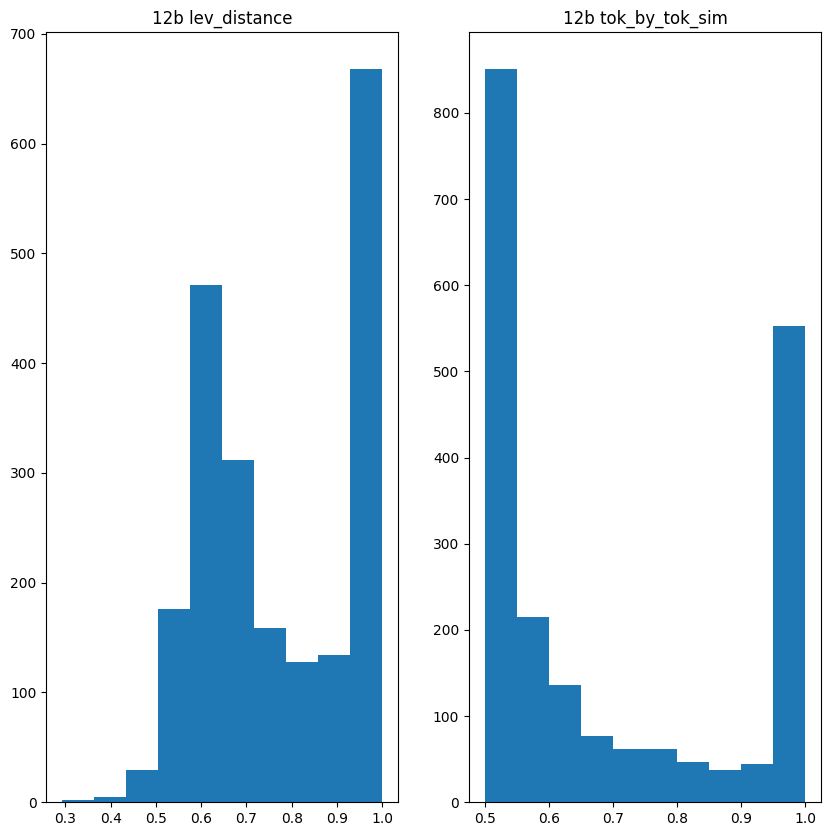

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].hist(df['lev_distance'])
ax[1].hist(df['tok_by_tok_sim'])
ax[0].set_title('12b lev_distance')
ax[1].set_title('12b tok_by_tok_sim')
plt.show()

In [75]:
neg = df[df['lev_distance'] <= 0.7]
pos = df[df['lev_distance'] >= 0.95]

print(len(neg), len(pos))

min_len = min(len(neg), len(pos))

positive_idxs = pos.index.tolist()
negative_idxs = neg.index.tolist()

import numpy as np
np.random.seed(0)
positive_idxs = np.random.choice(positive_idxs, min_len, replace=False)
negative_idxs = np.random.choice(negative_idxs, min_len, replace=False)

final_tokens = []
final_str = []
labels = []
for i in tqdm(positive_idxs): 
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(1)
for i in tqdm(negative_idxs):
    final_tokens.append(df['toks'][i])
    final_str.append(df['gen'][i])
    labels.append(0)

print(len(final_tokens), len(final_str), len(labels), len(df))
print(sum(labels)/len(labels))

937 604


100%|██████████| 604/604 [00:00<00:00, 97968.20it/s]

1208 1208 1208 2084
0.5


In [76]:
from datasets import Dataset, DatasetDict, load_from_disk
idxs = []
for i in positive_idxs: 
    idxs.append(int(df['orig_index'][i]))
for i in negative_idxs:
    idxs.append(int(df['orig_index'][i]))

mem_dist_dataset = Dataset.from_dict({'input_ids': final_tokens, 'text': final_str, 'labels': labels, 'orig_idx': idxs})
print(len(mem_dist_dataset))

mem_dist_dataset

1208


Dataset({
    features: ['input_ids', 'text', 'labels', 'orig_idx'],
    num_rows: 1208
})

In [77]:
generalization_datasets = DatasetDict({'fuzzy_pos': fuzzy_pos, 'prefix': prefix_dataset, 'mem_dist': mem_dist_dataset})
generalization_datasets.save_to_disk(os.path.join(path, 'generalization_datasets'))
generalization_datasets

Saving the dataset (1/1 shards): 100%|██████████| 1208/1208 [00:00<00:00, 321308.85 examples/s]


DatasetDict({
    fuzzy_pos: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 540
    })
    prefix: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 6355
    })
    mem_dist: Dataset({
        features: ['input_ids', 'text', 'labels', 'orig_idx'],
        num_rows: 1208
    })
})

# Cipher datasets

## Finetuning

In [78]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from functools import partial
import numpy as np
import torch
import os

path = '../../../gld/train-data-probes/data/1b'

seed = 0
set_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [79]:
def rotation_cipher(text, shift): 
    """
    Rotates the text by shift amount, character-wise. Also 
    known as the Caesar cipher.
    """
    shifted_text = []
    for char in text: 
        if char.isalpha():
            shifted_text.append(chr((ord(char) - ord('a') + shift) % 26 + ord('a')))
        else:
            shifted_text.append(char)
    return ''.join(shifted_text)

In [80]:
for shift in [3, 5, 7]:

    openwebtext = load_dataset('stas/openwebtext-10k')['train']
    openwebtext = openwebtext.map(lambda x: {'text': rotation_cipher(x['text'], shift)}, num_proc=4)
    
    # save
    openwebtext.save_to_disk(os.path.join(path, f'ciphers/rotated_{shift}'))

/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for stas/openwebtext-10k contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/stas/openwebtext-10k
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")
/home/ubuntu/anaconda3/envs/myenv/lib/python3.10/site-packages/datasets/download/download_manager.py:528: FutureWarning: 'num_proc' was deprecated in version 2.6.2 and will be removed in 3.0.0. Pass `DownloadConfig(nu

In [81]:
openwebtext

Dataset({
    features: ['text'],
    num_rows: 10000
})